**I. Loading dataset**

In [2]:
import pandas as pd

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 500)
#pd.set_option('display.max_colwidth', None)

df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


**II. Data preparation**

*II.1 Categories for supervised learning*

In [2]:
import re

# Collect labels
df['product_category_tree'] = df['product_category_tree'].apply(
    lambda x: re.split(' >>', x[2:]))
df['product_category_tree'] = df['product_category_tree'].apply(lambda x: x[0])

df['product_category_tree'].value_counts()

Beauty and Personal Care      150
Kitchen & Dining              150
Home Furnishing               150
Home Decor & Festive Needs    150
Computers                     150
Baby Care                     150
Watches                       150
Name: product_category_tree, dtype: int64

*II.2 Loading images and features extraction*

In [3]:
import cv2
import numpy as np

df['loaded_images'] = df['image'].apply(
    lambda x: cv2.imread('../P6/Images/' + x))

In [4]:
# Create images with gray scales
df['gray_images'] = df['loaded_images'].apply(
    lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2GRAY))

In [12]:
sift = cv2.SIFT_create()

keypoint, descriptor = sift.detectAndCompute(df['gray_images'][0], None)

df['gray_images'][0] = cv2.drawKeypoints(
    df['gray_images'][0],
    keypoint,
    df['gray_images'][0],
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('sift_keypoints_all_features.jpg', df['gray_images'][0])

<ipython-input-12-072e17406c17>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gray_images'][0] = cv2.drawKeypoints(


True

In [5]:
# Create SIFT model for features extaction
sift = cv2.SIFT_create()

keypoint = dict()
descriptor = dict()

# Store the SIFT keypoints and descriptors in 2 disctints dictionnaries
for idx, row in df.iterrows():
    keypoint[idx], descriptor[idx] = sift.detectAndCompute(
        row['gray_images'], None)

In [6]:
# Store the descriptors in the dF
desc = pd.Series(descriptor)
desc = desc.rename('descriptor')

df = pd.concat([df, desc], axis=1)

*II.3 Bag of features extraction*

In [7]:
# Select the 5 features below
df = df[['image', 'loaded_images', 'gray_images', 'descriptor', 'product_category_tree']]
df.head()

,image,loaded_images,gray_images,descriptor,product_category_tree
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[[[173, 184, 192], [173, 184, 192], [174, 185,...","[[185, 185, 186, 186, 186, 185, 184, 184, 185,...","[[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 11.0...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[19.0, 8.0, 2.0, 6.0, 17.0, 60.0, 27.0, 14.0,...",Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[95.0, 24.0, 0.0, 0.0, 2.0, 3.0, 2.0, 8.0, 18...",Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[0.0, 0.0, 0.0, 2.0, 7.0, 2.0, 2.0, 0.0, 2.0,...",Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,"[[[91, 99, 99], [72, 80, 80], [57, 67, 67], [5...","[[98, 79, 66, 61, 69, 80, 82, 87, 77, 72, 54, ...","[[92.0, 9.0, 8.0, 19.0, 4.0, 0.0, 2.0, 58.0, 1...",Home Furnishing


In [72]:
list_to_del = list()

# Collect all images index in a list if the image has no descriptors
for i, j in descriptor.items():
    if j is None:
        list_to_del.append(i)

# Delete images from list in descriptor dictionnary
if len(list_to_del) > 0:
    for i in list_to_del:
        descriptor.pop(i)

# Delete images from list in dF
df.drop(index=list_to_del, inplace=True)

In [9]:
# Concatenate all descriptor in one array
X_descriptor = np.concatenate([i for i in descriptor.values()])
X_descriptor.shape

(5977613, 128)

In [48]:
from sklearn.cluster import MiniBatchKMeans

distortions = list()
results = dict()
models = dict()

K = [1000]

for k in K:
    models[k] = MiniBatchKMeans(n_clusters=k,
                            random_state=0,
                            init='k-means++',
                            batch_size=50,
                            max_iter=10)
    results[k] = models[k].fit(X_descriptor)
    distortions.append(results[k].inertia_)
    print('Kmeans with', k, 'is completed')

Kmeans with 1000 is completed


In [49]:
models

{1000: MiniBatchKMeans(batch_size=50, max_iter=10, n_clusters=1000, random_state=0)}

In [50]:
def create_histogram(descriptor):
    """Function to create frequency histogram for each images"""
    histo = np.zeros(1000) 
    if descriptor is not None : 
        cluster_result =  models[1000].predict(descriptor) 
        for i in cluster_result: 
            histo[i] += 1.0 
    return histo

# Each histo is stored
histo_all_features = df.loc[:, 'descriptor'].apply(create_histogram) 

In [51]:
# And then, splitted to obtain 
visual_words = histo_all_features.apply(pd.Series)

# Record as csv to facilitate long term working
visual_words.to_csv('visual_words_all_features.csv') 

*II.4 Visual words*

In [3]:
visual_words = pd.read_csv('visual_words_all_features.csv')
visual_words.drop(columns='Unnamed: 0', inplace=True)

In [4]:
visual_words

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,...,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,18.0,183.0,81.0,223.0,31.0,48.0,75.0,20.0,40.0,57.0,25.0,39.0,84.0,0.0,252.0,1.0,128.0,22.0,75.0,169.0,65.0,37.0,41.0,19.0,953.0,3.0,17.0,9.0,58.0,36.0,27.0,150.0,316.0,65.0,6.0,38.0,36.0,37.0,44.0,25.0,31.0,24.0,10.0,335.0,105.0,93.0,31.0,77.0,108.0,48.0,34.0,130.0,19.0,18.0,26.0,20.0,11.0,10.0,12.0,19.0,286.0,10.0,41.0,94.0,36.0,15.0,45.0,11.0,67.0,145.0,61.0,20.0,163.0,101.0,70.0,81.0,42.0,23.0,92.0,0.0,43.0,55.0,21.0,26.0,96.0,74.0,82.0,43.0,13.0,25.0,48.0,29.0,433.0,72.0,16.0,27.0,164.0,47.0,27.0,28.0,53.0,38.0,36.0,11.0,172.0,83.0,34.0,40.0,19.0,535.0,143.0,78.0,8.0,133.0,11.0,107.0,1.0,3426.0,22.0,299.0,109.0,32.0,13.0,31.0,84.0,0.0,35.0,16.0,53.0,3.0,14.0,2968.0,658.0,53.0,25.0,15.0,44.0,9.0,6.0,50.0,1303.0,94.0,203.0,147.0,38.0,7.0,14.0,726.0,69.0,480.0,...,48.0,8.0,10.0,61.0,26.0,18.0,34.0,137.0,676.0,11.0,55.0,3.0,62.0,31.0,1.0,150.0,23.0,17.0,97.0,31.0,98.0,16.0,14.0,31.0,19.0,18.0,34.0,47.0,53.0,39.0,105.0,32.0,48.0,30.0,12.0,195.0,17.0,177.0,270.0,62.0,11.0,123.0,33.0,49.0,31.0,34.0,39.0,23.0,24.0,31.0,51.0,22.0,31.0,37.0,9.0,7.0,15.0,17.0,70.0,50.0,107.0,44.0,16.0,8.0,6.0,18.0,27.0,12.0,24.0,89.0,146.0,31.0,171.0,228.0,12.0,27.0,0.0,32.0,20.0,24.0,44.0,43.0,95.0,3.0,6.0,32.0,31.0,90.0,3.0,164.0,10.0,55.0,59.0,24.0,96.0,7.0,72.0,52.0,68.0,178.0,37.0,105.0,3.0,76.0,0.0,29.0,70.0,32.0,40.0,18.0,19.0,37.0,13.0,38.0,48.0,16.0,22.0,15.0,3.0,93.0,12.0,32.0,216.0,17.0,12.0,41.0,8.0,1218.0,30.0,28.0,46.0,72.0,25.0,10.0,13.0,15.0,40.0,107.0,55.0,64.0,51.0,11.0,22.0,210.0,5.0,10.0,89.0,85.0,7.0,20.0
1,17.0,48.0,7.0,5.0,11.0,135.0,56.0,26.0,4.0,76.0,6.0,2.0,20.0,1.0,27.0,1.0,13.0,49.0,5.0,42.0,92.0,12.0,10.0,41.0,19.0,19.0,25.0,6.0,26.0,33.0,10.0,18.0,5.0,5.0,34.0,71.0,1.0,4.0,84.0,0.0,83.0,44.0,29.0,0.0,9.0,32.0,29.0,46.0,38.0,26.0,1.0,4.0,4.0,1.0,12.0,33.0,2.0,8.0,49.0,12.0,15.0,18.0,29.0,14.0,89.0,4.0,44.0,7.0,42.0,6.0,16.0,20.0,2.0,5.0,8.0,29.0,36.0,4.0,87.0,1.0,98.0,2.0,9.0,2.0,10.0,13.0,24.0,14.0,0.0,42.0,40.0,58.0,5.0,29.0,15.0,16.0,97.0,27.0,27.0,0.0,105.0,46.0,3.0,30.0,18.0,97.0,6.0,17.0,32.0,7.0,0.0,0.0,36.0,63.0,46.0,62.0,0.0,7.0,21.0,76.0,36.0,20.0,47.0,44.0,3.0,0.0,10.0,6.0,32.0,7.0,24.0,17.0,2.0,26.0,23.0,5.0,45.0,12.0,39.0,15.0,2.0,29.0,6.0,32.0,37.0,0.0,3.0,6.0,50.0,10.0,...,19.0,6.0,32.0,14.0,3.0,10.0,13.0,13.0,42.0,43.0,19.0,1.0,1.0,14.0,0.0,17.0,51.0,41.0,63.0,5.0,0.0,10.0,20.0,8.0,10.0,13.0,11.0,17.0,9.0,17.0,12.0,48.0,40.0,40.0,43.0,19.0,8.0,48.0,3.0,28.0,59.0,20.0,8.0,32.0,18.0,20.0,13.0,87.0,18.0,64.0,36.0,0.0,22.0,7.0,51.0,0.0,3.0,1.0,36.0,22.0,26.0,30.0,71.0,14.0,0.0,39.0,4.0,2.0,13.0,28.0,117.0,15.0,24.0,19.0,12.0,24.0,2.0,39.0,14.0,18.0,53.0,25.0,9.0,5.0,20.0,83.0,9.0,17.0,45.0,43.0,3.0,95.0,2.0,22.0,14.0,25.0,29.0,43.0,5.0,13.0,59.0,3.0,29.0,9.0,0.0,38.0,6.0,12.0,8.0,74.0,40.0,66.0,9.0,31.0,52.0,7.0,14.0,7.0,12.0,60.0,39.0,91.0,12.0,5.0,2.0,35.0,0.0,26.0,12.0,24.0,1.0,5.0,53.0,13.0,73.0,30.0,49.0,19.0,13.0,100.0,25.0,13.

**III. Reduction of dimension and clustering**

In [6]:
from sklearn.preprocessing import Normalizer, StandardScaler

visual_words_normal = Normalizer().fit_transform(visual_words)
visual_words_std = StandardScaler().fit_transform(visual_words)

*III.1 PCA*

In [15]:
from sklearn import decomposition

n_components = 10

pca = decomposition.PCA(n_components=n_components)
reduced = pca.fit_transform(visual_words)

print(pca.explained_variance_ratio_.sum())

0.9335295661906692


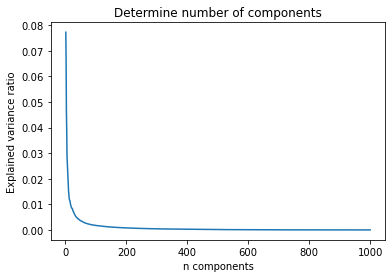

In [34]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1, n_components + 1), pca.explained_variance_ratio_)

plt.title('Determine number of components')
plt.xlabel('n components')
plt.ylabel('Explained variance ratio')

plt.show()

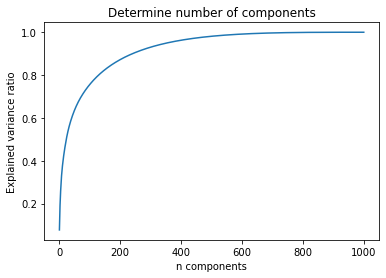

In [35]:
plt.plot(np.arange(1, n_components + 1),
         np.cumsum(pca.explained_variance_ratio_))

plt.title('Determine number of components')
plt.xlabel('n components')
plt.ylabel('Explained variance ratio')

plt.show()

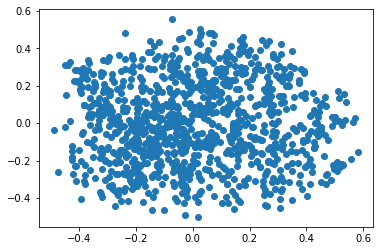

In [36]:
plt.scatter(reduced[:, 0], reduced[:, 1])

*III.2 tSNE*

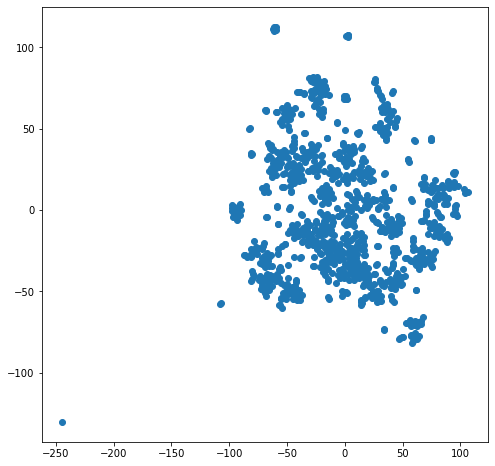

In [512]:
from sklearn.manifold import TSNE

tSNE_res = TSNE(n_components=2,
                perplexity=8,
                early_exaggeration=1,
                n_iter=4000,
                learning_rate=180
               ).fit_transform(visual_words_normal)

# Plot tSNE
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.scatter(tSNE_res[:, 0], tSNE_res[:, 1])
plt.show()

*III.3 Isomap*

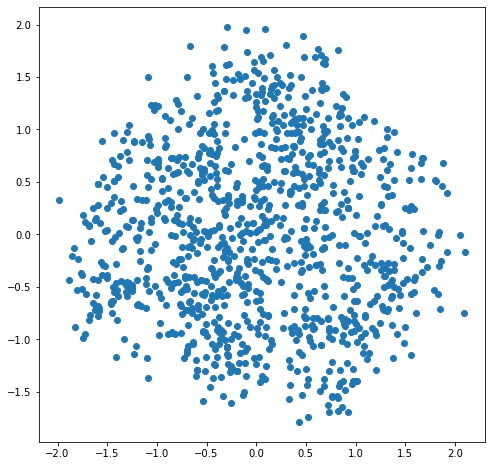

In [539]:
from sklearn.manifold import Isomap


Iso = Isomap(n_components=2, n_neighbors=15).fit_transform(visual_words_normal)

# Plot different Isomap results
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.scatter(Iso[:, 0], Iso[:, 1])
plt.show()

*III.4 DBScan & Kmeans*

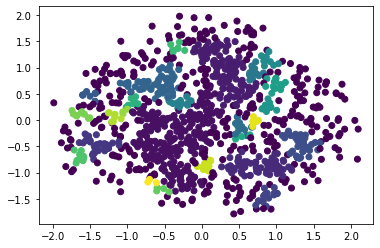

Silhouette Coefficient: -0.202
Davies Bouldin score: 1.573


In [673]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

eps = 0.12
spl = 7

db_res = DBSCAN(eps=eps, min_samples=spl).fit_predict(Iso)
plt.scatter(Iso[:, 0], Iso[:, 1], c=db_res)

plt.show()

yp = DBSCAN(eps=eps, min_samples=spl).fit(Iso)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(Iso, yp.labels_))

print("Davies Bouldin score: %0.3f"
      % metrics.davies_bouldin_score(Iso, yp.labels_))

In [678]:
from sklearn.cluster import KMeans, MiniBatchKMeans

distortions = list()

K = np.arange(1, 10, 1)

for k in K:
    # Initiate a model for each cluster
    model = MiniBatchKMeans(n_clusters=k, random_state=0, init='k-means++')
    # Stock the results of each cluster
    model.fit(reduced)
    # Obtain disto to plot results
    distortions.append(model.inertia_)

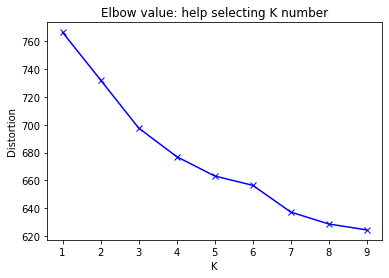

In [679]:
# Plot the results
plt.plot(K, distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.title('Elbow value: help selecting K number')

plt.show()

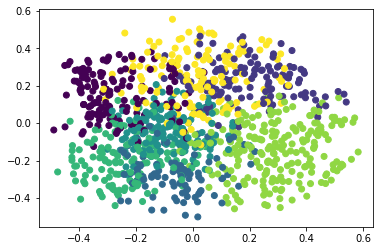

Silhouette Coefficient: 0.052
Davies Bouldin score: 3.568


In [677]:
kmeans = KMeans(n_clusters=7, init='k-means++').fit(reduced)
y_pred = kmeans.predict(reduced)

plt.scatter(reduced[:, 0], reduced[:, 1], c=y_pred)
plt.show()

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(reduced, kmeans.labels_))

print("Davies Bouldin score: %0.3f"
      % metrics.davies_bouldin_score(reduced, kmeans.labels_))

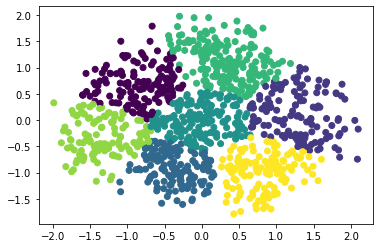

Silhouette Coefficient: 0.383
Davies Bouldin score: 0.772


In [676]:
kmeans = KMeans(n_clusters=7, init='k-means++').fit(Iso)
y_pred = kmeans.predict(Iso)

plt.scatter(Iso[:, 0], Iso[:, 1], c=y_pred)
plt.show()

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(Iso, kmeans.labels_))

print("Davies Bouldin score: %0.3f"
      % metrics.davies_bouldin_score(Iso, kmeans.labels_))

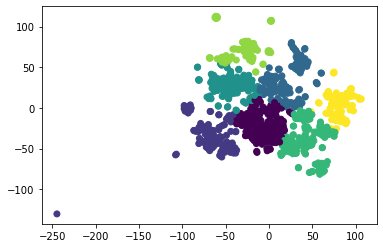

Silhouette Coefficient: 0.415
Davies Bouldin score: 0.761


In [515]:
kmeans = KMeans(n_clusters=7, init='k-means++').fit(tSNE_res)
y_pred = kmeans.predict(tSNE_res)

plt.scatter(tSNE_res[:, 0], tSNE_res[:, 1], c=y_pred)
plt.show()

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(tSNE_res, kmeans.labels_))

print("Davies Bouldin score: %0.3f"
      % metrics.davies_bouldin_score(tSNE_res, kmeans.labels_))

**IV. Benchmark some supervised learning**

In [16]:
# Run the notebook below to use needed function
%run P6_D_BenchmarkFunction.ipynb

In [17]:
# List of models are accepted by the function below
models_B = list([
    dum(),
    ran_for([50, 75, 100, 125], ['gini', 'entropy']),
    #grad_boo(['deviance'], [0.01, 0.1, 0.3, 0.5], [50, 75, 100, 125]),
    xg_boo([50, 75, 100, 125, 150, 175, 200], ['gbtree', 'dart']),
    knn([3, 5, 7, 9], ['uniform', 'distance']),
    svc(['l1', 'l2'], ['squared_hinge']),
    svc_kern([1.2], ['poly', 'rbf', 'sigmoid'])
])

In [78]:
# Launch the benchmark with standardizer
standard_results = model_benchmark(reduced, df['product_category_tree'], 'standard', models_B)
standard_results['perf'].round(2)

dummy is trained and fitted in 0.255 sec
random_forest is trained and fitted in 26.323 sec
xgboost is trained and fitted in 242.276 sec
knn is trained and fitted in 12.902 sec


C:\Users\DrDjekyl\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\DrDjekyl\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\DrDjekyl\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\DrDjekyl\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\DrDjekyl\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the numbe

svc is trained and fitted in 333.643 sec
svc_kernel is trained and fitted in 18.038 sec


,svc_kernel,svc,knn,xgboost,random_forest,dummy
Train Accuracy,0.34,0.48,0.45,0.54,0.51,0.15
Test Accuracy,0.38,0.53,0.46,0.55,0.47,0.12
Time,18.04,333.64,12.90,242.28,26.32,0.25


In [79]:
# Launch the benchmark with normalizer
normal_results = model_benchmark(visual_words, df['product_category_tree'], 'normal', models_B)
normal_results['perf'].round(2)

dummy is trained and fitted in 0.201 sec
random_forest is trained and fitted in 47.631 sec
xgboost is trained and fitted in 350.240 sec
knn is trained and fitted in 14.138 sec


C:\Users\DrDjekyl\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\DrDjekyl\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\DrDjekyl\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\DrDjekyl\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\DrDjekyl\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the numbe

svc is trained and fitted in 9.732 sec
svc_kernel is trained and fitted in 18.096 sec


,svc_kernel,svc,knn,xgboost,random_forest,dummy
Train Accuracy,0.52,0.54,0.45,0.54,0.51,0.15
Test Accuracy,0.54,0.54,0.46,0.52,0.48,0.12
Time,18.10,9.73,14.14,350.24,47.63,0.20


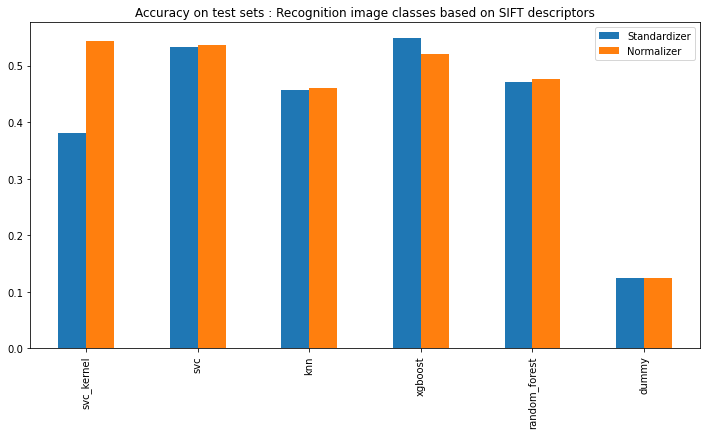

In [80]:
# Concatenate the results
all_results = pd.concat([
    standard_results['perf'],
    normal_results['perf']
])

# Plot the results
title = 'Accuracy on test sets : Recognition image classes based on SIFT descriptors'
ax = all_results.iloc[[1, 4], :].T.plot.bar(figsize=(12, 6), title=title)
ax.legend(['Standardizer', 'Normalizer']);